In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import models, layers, regularizers, metrics, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
from scipy import stats
import shutil
import random
from sklearn.metrics import confusion_matrix

In [ ]:
def dataset_basic_info(generator, name):
        print('The ' + name + ' dataset includes ' + str(generator.samples) + ' samples.')
        print('The ' + name + ' image shapes is ' + str(generator.image_shape))
        keys = [el for el in generator.class_indices.keys()]
        print('The ' + name + ' dataset includes the following labels: ')
        print(keys)
        labels     = generator.labels
        cat_labels = []
        for i in range(len(labels)):
            for j in range(len(keys)):
                if (labels[i] == j):
                    cat_labels.append(keys[j])
                    break
        occurrences = []
        for key in keys:
            counter = 0
            for i in range(len(cat_labels)):
                if cat_labels[i] == key:
                    counter += 1
            occurrences.append(counter)
        print(name + ' data set labels frequencies:')
        weights = {}
        for i in range(len(keys)):
            print(keys[i] + ': ' + str(occurrences[i]) + ' (absolute), ' + str(round(occurrences[i]/float(generator.samples), 3)) + ' (relative).' )
            weights[i] = generator.samples/np.array(occurrences[i])*(1.0/float(len(keys)))
        
        return weights
 
 
def build_model_cnn(regression_problem, conv_filters, conv_filter_shape, conv_activation_function, conv_padding, conv_pooling_type, conv_pooling_shape, hidden_layers_neurons, hidden_activation_function, L1_coeffs, L2_coeffs, hidden_layers_dropout, final_layer_neurons, final_activation_function, shape, model_optimizer, loss_function, metrics):
    
    model = models.Sequential()
    
    for i in range(len(conv_activation_function)):
        
        if (i == 0):
            model.add(layers.Conv2D(conv_filters[i],
                                    (conv_filter_shape[i][0],conv_filter_shape[i][1]), 
                                    activation = conv_activation_function[i], 
                                    padding    = conv_padding[i],
                                    input_shape = (shape[0],shape[1],shape[2])))             
        else:
            model.add(layers.Conv2D(conv_filters[i],
                                    (conv_filter_shape[i][0],conv_filter_shape[i][1]), 
                                    activation = conv_activation_function[i],
                                    padding    = conv_padding[i]))
        
        if (conv_pooling_type[i] == 'max'):
            model.add(layers.MaxPooling2D((conv_pooling_shape[i][0],conv_pooling_shape[i][1])))
        elif (conv_pooling_type[i] == 'avg'):
            model.add(layers.AveragePooling2D((conv_pooling_shape[i][0],conv_pooling_shape[i][1])))
        else:
            'no pooling'
            
    model.add(layers.Flatten())
    
    for i in range(len(hidden_activation_function)):
 
        model.add(layers.Dense(hidden_layers_neurons[i], 
                               kernel_regularizer = regularizers.l1_l2(l1 = L1_coeffs[i], l2 =  L2_coeffs[i]),  
                               activation=hidden_activation_function[i]))
        if (hidden_layers_dropout[i] > 0.0):
            model.add(layers.Dropout(hidden_layers_dropout[i]))
    if regression_problem:
            model.add(layers.Dense(final_layer_neurons))
    else:
            model.add(layers.Dense(final_layer_neurons,activation = final_activation_function))
            
    model.compile(optimizer = model_optimizer, loss = loss_function, metrics = metrics)
    
    model.summary()
    
    return model
 
def build_model_pretrained_cnn(pre_trained_model, include_top, regression_problem, hidden_layers_neurons, hidden_activation_function, L1_coeffs, L2_coeffs, hidden_layers_dropout, final_layer_neurons, final_activation_function, model_optimizer, loss_function, metrics):
    
    model = models.Sequential() #stack
    model.add(pre_trained_model)
    
    if (include_top == False):
        
            model.add(layers.Flatten())
 
            for i in range(len(hidden_activation_function)):
 
                model.add(layers.Dense(hidden_layers_neurons[i], 
                                       kernel_regularizer = regularizers.l1_l2(l1 = L1_coeffs[i], l2 =  L2_coeffs[i]),  
                                       activation=hidden_activation_function[i]))
                if (hidden_layers_dropout[i] > 0.0):
                    model.add(layers.Dropout(hidden_layers_dropout[i]))
            if regression_problem:
                    model.add(layers.Dense(final_layer_neurons))
            else:
                    model.add(layers.Dense(final_layer_neurons,activation = final_activation_function))
            
    model.compile(optimizer = model_optimizer, loss = loss_function, metrics = metrics)
    
    model.summary()
    
    return model
 
def display_input_images(generator, max_n_figures, batch_size, grid_size, fig_size):
    
    fig_counter = 0
    for image_batch, label_batch in generator: 
        plt.figure(figsize=(fig_size[0],fig_size[1]))
        for j in range(batch_size):
            ax   = plt.subplot(grid_size[0], grid_size[1], j + 1)
            plt.imshow(image_batch[j])
            if (label_batch[j][0] == 1):
                    plt.title('MildDemented')
            elif (label_batch[j][1] == 1):
                    plt.title('ModerateDemented')
            elif (label_batch[j][2] == 1):
                    plt.title('NonDemented')
            else:
                    plt.title('VeryMildDemented')
            plt.axis("off")
        plt.show()
        fig_counter += 1
        if (fig_counter == max_n_figures): break
 
def analyze_performances(hst, epochs):
    history_dict             = hst.history
    loss_values              = history_dict['loss']
    validation_loss_values   = history_dict['val_loss']
    acc_values               = history_dict['categorical_accuracy']
    validation_acc_values    = history_dict['val_categorical_accuracy']
    auc_values               = history_dict['multiclass_AUC']
    validation_auc_values    = history_dict['val_multiclass_AUC']
    epochs                   = range(1,len(loss_values) + 1)
    fig, axes                = plt.subplots(1,3,figsize = (30,10))
    training_ts              = [loss_values, acc_values, auc_values]
    validation_ts            = [validation_loss_values, validation_acc_values, validation_auc_values]
    metric_names             = ['loss', 'categorical accuracy','average multiclass AUC']
    for i in range(len(axes)):
        axes[i].plot(epochs,training_ts[i],color = 'r',label = 'training')
        axes[i].plot(epochs,validation_ts[i],color = 'b',label = 'validation')
        axes[i].set_xlabel('epoch')
        axes[i].set_ylabel(metric_names[i])
        axes[i].set_title(metric_names[i] + ' analysis')
        axes[i].set_xticks(np.arange(0,epochs[-1] + 1,5))
        axes[i].set_yticks(np.arange(0,1.1,0.1))
        axes[i].set_xlim([1,epochs[-1]])
        axes[i].set_ylim([np.min([np.min(training_ts[i]),np.min(validation_ts[i])]),np.max([np.max(training_ts[i]),np.max(validation_ts[i])])])
        axes[i].legend()
    plt.show()
 
 
def model_evaluation(model, test_generator):
    test_loss_1, test_acc_1, test_auc_1 = model.evaluate_generator(test_generator, verbose=0)
    print('The value of the loss function on the test data set is: ' + str(round(test_loss_1,4)))
    print('The categorical accuracy of the predictions on the test data set is: ' + str(round(test_acc_1,4)))
    print('The categorical AUC (i.e., average curve across classes) of the predictions on the test data set is: ' + str(round(test_auc_1,4)))
    
    class_labels = list(test_generator.class_indices.keys())
    predictions = []
    true        = []
    ctr         = 0
    for batch, label in test_generator:
        prediction = model.predict(batch).argmax(axis = -1)
        predictions.extend(prediction)
        true.extend(label.argmax(axis = -1))
        ctr += len(prediction)
        if ctr >= len(test_generator.labels):
            break
            
    matrix     = confusion_matrix(true,predictions)
    rel_matrix = matrix/np.sum(matrix,axis = 0)
    fig, axes  = plt.subplots(1,2,figsize = (20,40))
 
    image1 = axes[0].imshow(matrix, cmap=plt.get_cmap('GnBu'))
    for (i, j), e in np.ndenumerate(matrix):
        axes[0].text(j, i, s = str(e), ha='center', va='center')
    axes[0].set_xticks(np.arange(0,len(class_labels), 1))
    axes[0].set_xticklabels(class_labels)
    axes[0].set_yticks(np.arange(0,len(class_labels), 1))
    axes[0].set_yticklabels(class_labels)
    axes[0].set_title('Confusion Matrix')
    
    image2 = axes[1].imshow(matrix/np.sum(matrix,axis = 0), cmap=plt.get_cmap('GnBu'))
    for (i, j), e in np.ndenumerate(rel_matrix):
        axes[1].text(j, i, s = str(np.round(e,2)), ha='center', va='center')
    axes[1].set_xticks(np.arange(0,len(class_labels), 1))
    axes[1].set_xticklabels(class_labels)
    axes[1].set_yticks(np.arange(0,len(class_labels), 1))
    axes[1].set_yticklabels(class_labels)
    plt.subplots_adjust(wspace = 0.5)
    axes[1].set_title('Confusion Matrix (Relative)')                      
    plt.show()

In [ ]:
DATA_DIR = '/content/drive/MyDrive/Alzheimer Detection'

training_path                  =  DATA_DIR + "/Alzheimer_s Dataset/train/"
test_path                      =  DATA_DIR + "/Alzheimer_s Dataset/test/"
validation_split               = 0.20
regression_problem             = False
target_img_shape_1             = 224
target_img_shape_2             = 224
target_img_channels            = 3
conv_layers                    = 4
conv_filters                   = [32,64,128,128]   
conv_filter_shape              = [[3,3]]*conv_layers
conv_activation_function       = ['relu']*conv_layers
conv_padding                   = ['valid']*conv_layers
conv_pooling_type              = ['max']*conv_layers
conv_pooling_shape             = [[2,2]]*conv_layers
augment_data                   = True
rotation_range                 = 0.1
width_shift_range              = 0.1
height_shift_range             = 0.1
shear_range                    = 0.1
brightness_range               = [0.8,1.2]
zoom_range                     = 0.1
horizontal_flip                = False
fill_mode                      = 'nearest'
print_sample_input             = True
hidden_activation_function     = ['relu']
hidden_layers_neurons          = [128]
hidden_layers_L1_coeffs        = [0.00]
hidden_layers_L2_coeffs        = [0.00]
hidden_layers_dropout          = [0.00]
final_activation_function      = 'softmax'
final_layer_neurons            = 4
model_optimizer                = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #important
loss_function                  = 'categorical_crossentropy'
metrics                        = [metrics.CategoricalAccuracy(name='categorical_accuracy'), #important
                                  metrics.AUC(multi_label = True, name='multiclass_AUC')]
n_epochs                       = 40
batch_size                     = 40
validation_steps               = 50
vgg_include_top                = True
vgg_hidden_activation_function = ['relu']
vgg_hidden_layers_neurons      = [128]
vgg_hidden_layers_L1_coeffs    = [0.00]
vgg_hidden_layers_L2_coeffs    = [0.00]
vgg_hidden_layers_dropout      = [0.00]
vgg_final_activation_function  = 'softmax'
vgg_final_layer_neurons        = 4
vgg_model_optimizer            = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
vgg_n_epochs                   = 40
vgg_validation_steps           = 50

In [ ]:
class CropLeftHC(object):
    """Crops the left hippocampus of a MRI non-linearly registered to MNI"""
    def __init__(self, random_shift=0):
        self.random_shift = random_shift
        self.train_mode = True
    def __call__(self, img):
        if self.train_mode:
            x = random.randint(-self.random_shift, self.random_shift)
            y = random.randint(-self.random_shift, self.random_shift)
            z = random.randint(-self.random_shift, self.random_shift)
        else:
            x, y, z = 0, 0, 0
        return img[:, 25 + x:55 + x,
                   50 + y:90 + y,
                   27 + z:57 + z].clone()

    def train(self):
        self.train_mode = True

    def eval(self):
        self.train_mode = False

class CropRightHC(object):
    """Crops the right hippocampus of a MRI non-linearly registered to MNI"""
    def __init__(self, random_shift=0):
        self.random_shift = random_shift
        self.train_mode = True
    def __call__(self, img):
        if self.train_mode:
            x = random.randint(-self.random_shift, self.random_shift)
            y = random.randint(-self.random_shift, self.random_shift)
            z = random.randint(-self.random_shift, self.random_shift)
        else:
            x, y, z = 0, 0, 0
        return img[:, 65 + x:95 + x,
                   50 + y:90 + y,
                   27 + z:57 + z].clone()

    def train(self):
        self.train_mode = True

    def eval(self):
        self.train_mode = False

In [ ]:
labels              = ['MildDemented','ModerateDemented','NonDemented', 'VeryMildDemented']
new_training_path   = DATA_DIR + "/Alzheimer_s Dataset/training_set/"
new_validation_path = DATA_DIR + "/Alzheimer_s Dataset/validation_set/"
new_test_path       = DATA_DIR + "/Alzheimer_s Dataset/test_set/"
shutil.rmtree(new_training_path, ignore_errors=True)
shutil.rmtree(new_validation_path, ignore_errors=True) 
shutil.rmtree(new_test_path, ignore_errors=True)
[os.makedirs(new_training_path + label,exist_ok=True) for label in labels]
[os.makedirs(new_validation_path + label,exist_ok=True) for label in labels]
[os.makedirs(new_test_path + label,exist_ok=True) for label in labels]
training_label_frequencies   = []
for label in labels:
        training_filenames   = os.listdir(training_path + label + "/") 
        validation_filenames = random.sample(training_filenames, int(len(training_filenames)*validation_split))
        training_filenames   = [file for file in training_filenames if file not in validation_filenames]
        test_filenames       = os.listdir(test_path + label + "/") 
        for file in training_filenames:
            shutil.copy(training_path + label + "/" + file, new_training_path + label + "/" + file)
        print('Training images transfer complete for label: ' + label + '. # transferred images: ' + str(len(training_filenames)))
        for file in validation_filenames:
            shutil.copy(training_path + label + "/" + file, new_validation_path + label + "/" + file)
        print('Validation images transfer complete for label: ' + label + '. # transferred images: '  + str(len(validation_filenames)))
        for file in test_filenames:
            shutil.copy(test_path + label + "/" + file, new_test_path + label + "/" + file)
        print('Test images transfer complete for label: ' + label + '. # transferred images: '  + str(len(test_filenames)))
        
        training_label_frequencies.append(len(training_filenames))


Training images transfer complete for label: MildDemented. # transferred images: 574
Validation images transfer complete for label: MildDemented. # transferred images: 143
Test images transfer complete for label: MildDemented. # transferred images: 179
Training images transfer complete for label: ModerateDemented. # transferred images: 42
Validation images transfer complete for label: ModerateDemented. # transferred images: 10
Test images transfer complete for label: ModerateDemented. # transferred images: 12
Training images transfer complete for label: NonDemented. # transferred images: 2048
Validation images transfer complete for label: NonDemented. # transferred images: 512
Test images transfer complete for label: NonDemented. # transferred images: 640
Training images transfer complete for label: VeryMildDemented. # transferred images: 1434
Validation images transfer complete for label: VeryMildDemented. # transferred images: 358
Test images transfer complete for label: VeryMildDeme

In [ ]:
training_label_frequencies = np.array(training_label_frequencies)
target_n_samples           = np.max(training_label_frequencies)
for i in range(len(labels)):
    current_label     = labels[i]
    n_missing_samples = target_n_samples - training_label_frequencies[i]
    filenames         = os.listdir(new_training_path + current_label + "/") 
    n_filled          = np.zeros(len(filenames))
    while (np.sum(n_filled) < n_missing_samples):
          idx = np.random.randint(0,len(filenames))
          shutil.copy(new_training_path + current_label + "/" + filenames[idx], new_training_path + current_label + "/" + filenames[idx].replace(".jpg", "_copy_" + str(int(n_filled[idx] + 1)) + ".jpg"))
          n_filled[idx] += 1
    

In [ ]:
new_training_path   = DATA_DIR + "/Alzheimer_s Dataset/training_set/"
new_validation_path = DATA_DIR + "/Alzheimer_s Dataset/validation_set/"
new_test_path       = DATA_DIR + "/Alzheimer_s Dataset/test_set/"

if augment_data:
    train_datagen   = ImageDataGenerator(rescale            = 1./255,
                                         rotation_range     = rotation_range,
                                         width_shift_range  = width_shift_range,
                                         height_shift_range = height_shift_range,
                                         shear_range        = shear_range,
                                         brightness_range   = brightness_range,
                                         zoom_range         = zoom_range,
                                         horizontal_flip    = horizontal_flip,
                                         fill_mode          = fill_mode)
else:
    train_datagen   = ImageDataGenerator(rescale = 1./255)

validation_datagen   = ImageDataGenerator(rescale = 1./255)
test_datagen         = ImageDataGenerator(rescale = 1./255)
train_generator      = train_datagen.flow_from_directory(new_training_path,target_size = (target_img_shape_1, target_img_shape_2), batch_size = batch_size, class_mode = "categorical")  
validation_generator = validation_datagen.flow_from_directory(new_validation_path,target_size = (target_img_shape_1, target_img_shape_2), batch_size = batch_size, class_mode = "categorical") 
test_generator       = test_datagen.flow_from_directory(new_test_path,target_size = (target_img_shape_1, target_img_shape_2), batch_size = batch_size, class_mode = "categorical") 

Found 8192 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
if print_sample_input:
    display_input_images(train_generator, 2, batch_size, [8,5], [30,30])

In [ ]:
train_labels_weights_dict      = dataset_basic_info(train_generator, 'training')
validation_labels_weights_dict = dataset_basic_info(validation_generator, 'validation')
test_labels_weights_dict       = dataset_basic_info(test_generator, 'test')

The training dataset includes 8192 samples.
The training image shapes is (224, 224, 3)
The training dataset includes the following labels: 
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
training data set labels frequencies:
MildDemented: 2048 (absolute), 0.25 (relative).
ModerateDemented: 2048 (absolute), 0.25 (relative).
NonDemented: 2048 (absolute), 0.25 (relative).
VeryMildDemented: 2048 (absolute), 0.25 (relative).
The validation dataset includes 1023 samples.
The validation image shapes is (224, 224, 3)
The validation dataset includes the following labels: 
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
validation data set labels frequencies:
MildDemented: 143 (absolute), 0.14 (relative).
ModerateDemented: 10 (absolute), 0.01 (relative).
NonDemented: 512 (absolute), 0.5 (relative).
VeryMildDemented: 358 (absolute), 0.35 (relative).
The test dataset includes 1279 samples.
The test image shapes is (224, 224, 3)
The test dataset incl

In [ ]:
model = build_model_cnn(regression_problem, conv_filters, conv_filter_shape, conv_activation_function, conv_padding, conv_pooling_type, conv_pooling_shape, hidden_layers_neurons, hidden_activation_function, 
                             hidden_layers_L1_coeffs, hidden_layers_L2_coeffs, hidden_layers_dropout, final_layer_neurons, final_activation_function, [target_img_shape_1, target_img_shape_2, target_img_channels], 
                             model_optimizer, loss_function, metrics)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1

In [ ]:
early_exit      = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')
best_checkpoint = ModelCheckpoint(DATA_DIR + '/best_fit.hdf5', save_best_only=True, monitor='val_multiclass_AUC', mode='max')

hst = model.fit(train_generator, steps_per_epoch = train_generator.samples//batch_size, epochs = n_epochs, validation_data = validation_generator, validation_steps = validation_generator.samples//batch_size, callbacks =[early_exit, best_checkpoint])

In [ ]:
model.load_weights(filepath = DATA_DIR + '/best_fit.hdf5')

In [ ]:
analyze_performances(hst, n_epochs)

In [ ]:
pre_trained_conv = VGG19(weights = 'imagenet', include_top = False, classes = 4, classifier_activation="softmax", input_shape = (target_img_shape_1, target_img_shape_2, target_img_channels))

In [ ]:
model_pt = build_model_pretrained_cnn(pre_trained_conv, False, regression_problem, vgg_hidden_layers_neurons, vgg_hidden_activation_function, vgg_hidden_layers_L1_coeffs, vgg_hidden_layers_L2_coeffs, vgg_hidden_layers_dropout, vgg_final_layer_neurons, vgg_final_activation_function, vgg_model_optimizer, loss_function, metrics)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K


In [ ]:
base_model = ResNet50(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6422592   
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation (Activation)      (None, 64)               

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=metrics)

In [ ]:
early_exit      = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')
best_checkpoint = ModelCheckpoint(DATA_DIR + '/best_fit.hdf5', save_best_only=True, monitor='val_multiclass_AUC', mode='max')

hst = model.fit(train_generator, steps_per_epoch = train_generator.samples//batch_size, epochs = n_epochs, validation_data = validation_generator, validation_steps = validation_generator.samples//batch_size, callbacks =[early_exit, best_checkpoint])

Epoch 1/40
204/204 [==============================] - 152s 565ms/step - loss: 1.5518 - categorical_accuracy: 0.2523 - multiclass_AUC: 0.5026 - val_loss: 1.3874 - val_categorical_accuracy: 0.2340 - val_multiclass_AUC: 0.6091
Epoch 2/40
204/204 [==============================] - 113s 556ms/step - loss: 1.4108 - categorical_accuracy: 0.2731 - multiclass_AUC: 0.5303 - val_loss: 1.3417 - val_categorical_accuracy: 0.3340 - val_multiclass_AUC: 0.6198
Epoch 3/40
204/204 [==============================] - 114s 557ms/step - loss: 1.3837 - categorical_accuracy: 0.2891 - multiclass_AUC: 0.5454 - val_loss: 1.2541 - val_categorical_accuracy: 0.4350 - val_multiclass_AUC: 0.6608
Epoch 4/40
204/204 [==============================] - 114s 559ms/step - loss: 1.3035 - categorical_accuracy: 0.3553 - multiclass_AUC: 0.6249 - val_loss: 1.0997 - val_categorical_accuracy: 0.4740 - val_multiclass_AUC: 0.7466
Epoch 5/40
204/204 [==============================] - 114s 556ms/step - loss: 1.2388 - categorical_accur

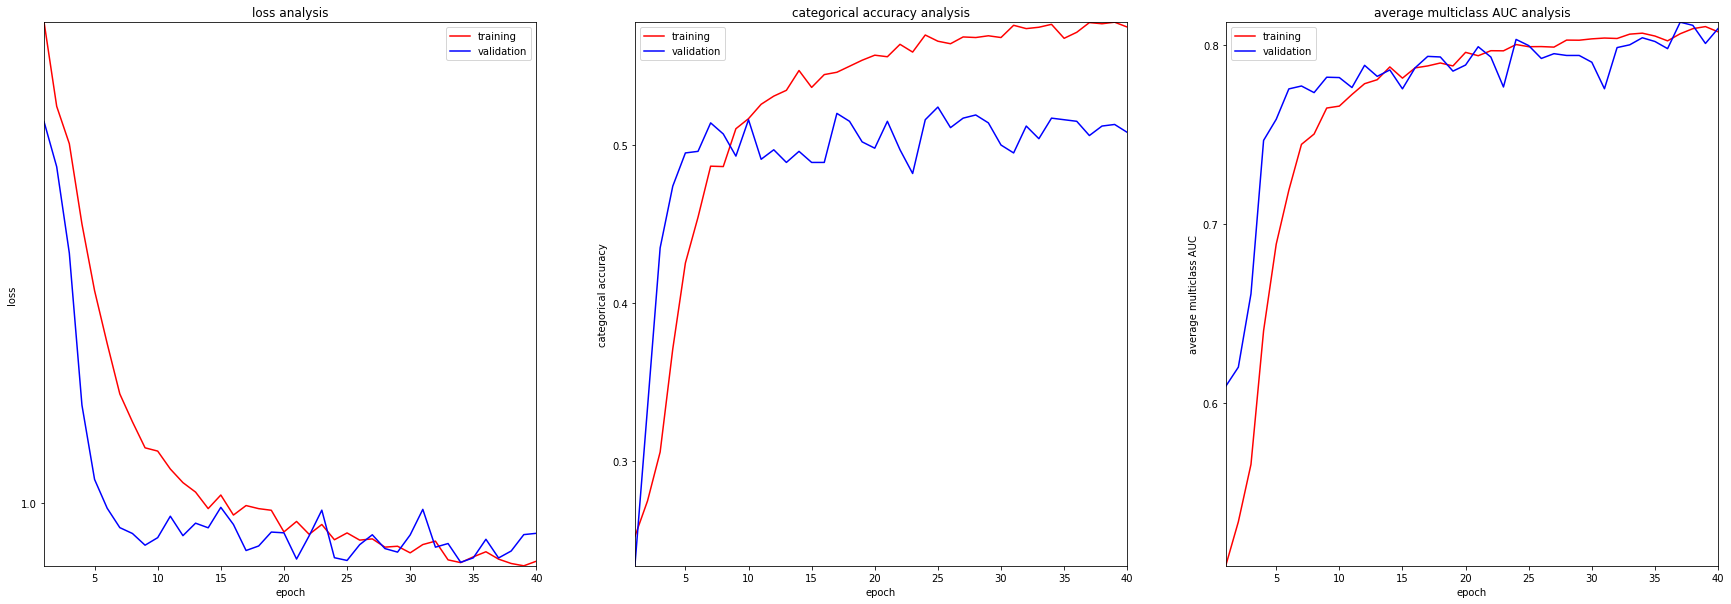

In [ ]:
analyze_performances(hst, n_epochs)

In [ ]:
model.save(DATA_DIR + "/resnet_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Alzheimer Detection/resnet_model/assets


In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
base_model = VGG19(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")
for layer in base_model.layers:
    layer.trainable=False
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [ ]:
OPT    = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=metrics,
              optimizer=OPT)

In [ ]:
early_exit      = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')
best_checkpoint = ModelCheckpoint(DATA_DIR + '/best_fit.hdf5', save_best_only=True, monitor='val_multiclass_AUC', mode='max')

hst = model.fit(train_generator, steps_per_epoch = train_generator.samples//batch_size, epochs = n_epochs, validation_data = validation_generator, validation_steps = validation_generator.samples//batch_size, callbacks =[early_exit, best_checkpoint])

Epoch 1/40
204/204 [==============================] - 139s 632ms/step - loss: 1.3211 - categorical_accuracy: 0.5175 - multiclass_AUC: 0.7532 - val_loss: 0.7327 - val_categorical_accuracy: 0.6920 - val_multiclass_AUC: 0.8958
Epoch 2/40
204/204 [==============================] - 125s 613ms/step - loss: 0.8021 - categorical_accuracy: 0.6647 - multiclass_AUC: 0.8686 - val_loss: 0.6313 - val_categorical_accuracy: 0.7230 - val_multiclass_AUC: 0.9111
Epoch 3/40
204/204 [==============================] - 136s 667ms/step - loss: 0.6851 - categorical_accuracy: 0.7073 - multiclass_AUC: 0.8949 - val_loss: 0.5766 - val_categorical_accuracy: 0.7450 - val_multiclass_AUC: 0.9290
Epoch 4/40
204/204 [==============================] - 122s 598ms/step - loss: 0.6123 - categorical_accuracy: 0.7379 - multiclass_AUC: 0.9140 - val_loss: 0.4792 - val_categorical_accuracy: 0.7810 - val_multiclass_AUC: 0.9515
Epoch 5/40
204/204 [==============================] - 122s 597ms/step - loss: 0.5590 - categorical_accur

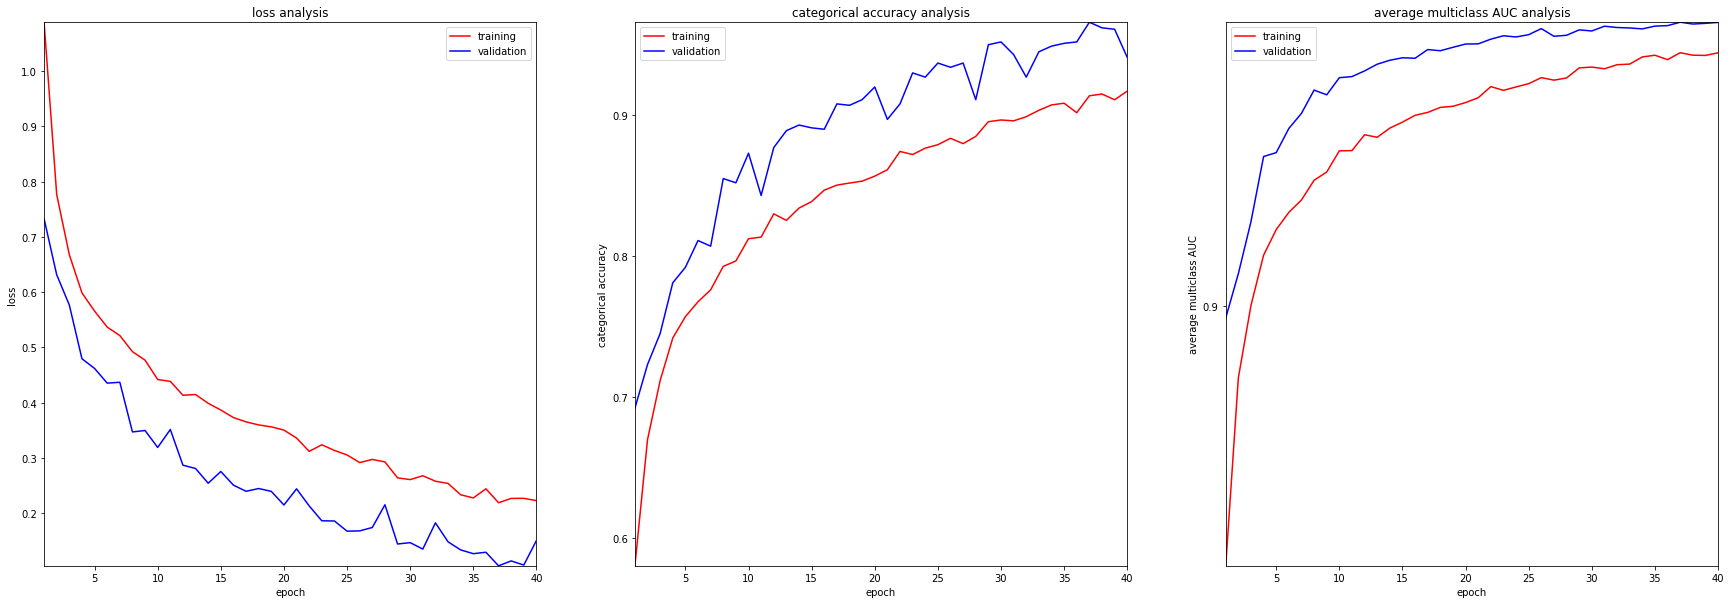

In [ ]:
analyze_performances(hst, n_epochs)

In [ ]:
model.save(DATA_DIR + "/vgg19_model")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D

from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
base_model = DenseNet121(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")
for layer in base_model.layers:
    layer.trainable=False
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50176)             200704    
_________________________________________________________________
dense (Dense)                (None, 64)                3211328   
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation (Activation)      (None, 64)               

In [ ]:
import keras as K
import tensorflow as tf
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
]
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=metrics)


In [ ]:
history=model.fit(train_generator,
                        validation_data=validation_generator,
                        epochs = 40,
                        verbose = 1,
                         callbacks=lr_scheduler)

model.save(DATA_DIR + "/densenet121_model")

Epoch 1/40
205/205 [==============================] - 157s 572ms/step - loss: 1.3850 - accuracy: 0.7477 - precision: 0.4532 - recall: 0.0518 - auc: 0.5718 - val_loss: 1.1640 - val_accuracy: 0.7559 - val_precision: 0.5659 - val_recall: 0.1007 - val_auc: 0.7341
Epoch 2/40
205/205 [==============================] - 112s 547ms/step - loss: 0.9001 - accuracy: 0.8092 - precision: 0.8798 - recall: 0.2748 - auc: 0.8282 - val_loss: 0.8491 - val_accuracy: 0.8040 - val_precision: 0.7356 - val_recall: 0.3372 - val_auc: 0.8467
Epoch 3/40
205/205 [==============================] - 112s 545ms/step - loss: 0.8218 - accuracy: 0.8189 - precision: 0.8155 - recall: 0.3565 - auc: 0.8705 - val_loss: 0.8424 - val_accuracy: 0.7999 - val_precision: 0.6796 - val_recall: 0.3773 - val_auc: 0.8474
Epoch 4/40
205/205 [==============================] - 112s 546ms/step - loss: 0.7679 - accuracy: 0.8286 - precision: 0.7591 - recall: 0.4610 - auc: 0.8861 - val_loss: 0.8303 - val_accuracy: 0.8016 - val_precision: 0.6672

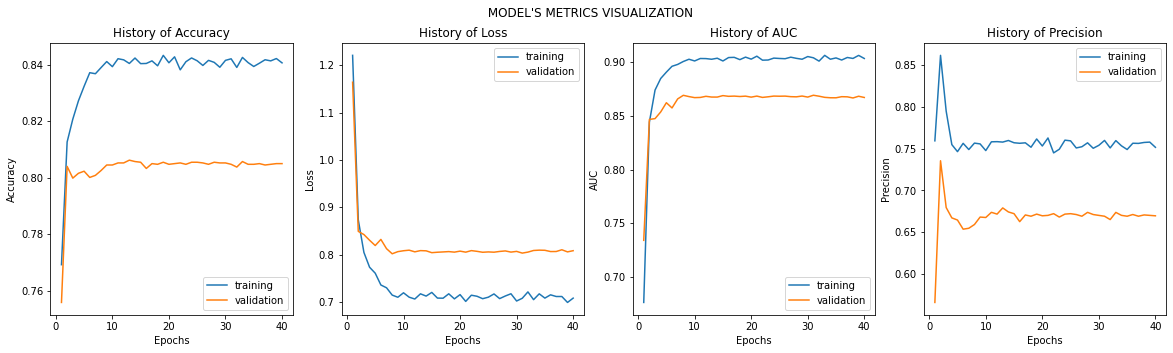

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
              )


In [ ]:
scores = model.evaluate_generator(test_generator)
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Accuracy =  0.7900703549385071
Precision =  0.6215895414352417
Recall =  0.4096950888633728
AUC =  0.8419510722160339
